In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import os
RESEARCH_DIR = "/content/drive/MyDrive/models/research"

In [5]:
os.getcwd()

'/content'

In [6]:
os.chdir(RESEARCH_DIR)

In [7]:
os.getcwd()

'/content/drive/MyDrive/models/research'

In [ ]:
--!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
--!tar xzvf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [7]:
--!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
--!tar xzvf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

--2021-04-26 04:51:27--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.7.208, 2607:f8b0:4004:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.7.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76541073 (73M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’

ssd_mobilenet_v1_co 100%[===================>]  73.00M  82.1MB/s    in 0.9s    

2021-04-26 04:51:28 (82.1 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.tar.gz’ saved [76541073/76541073]

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1_

In [8]:
!pip install tf_slim

In [ ]:
from datetime import datetime
start = datetime.now()

!python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_mobilenet_v1_coco.config

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [11]:
os.getcwd()

'/content/drive/My Drive/models/research'

In [14]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/ssd_mobilenet_v1_coco.config --trained_checkpoint_prefix training/model.ckpt-40272 --output_directory my_model

Instructions for updating:
Please use `layer.__call__` method instead.
W0426 10:51:29.289281 140357776766848 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0426 10:51:31.282329 140357776766848 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0426 10:51:31.331649 140357776766848 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0426 10:51:31.389433 140357776766848 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [15]:
path = "/content/drive/MyDrive/models/research/my_model"
os.chdir(path)
!zip results.zip *

  adding: checkpoint (deflated 42%)
  adding: frozen_inference_graph.pb (deflated 9%)
  adding: model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: model.ckpt.index (deflated 68%)
  adding: model.ckpt.meta (deflated 94%)
  adding: pipeline.config (deflated 69%)
  adding: saved_model/ (stored 0%)


In [17]:
path = "/content/drive/MyDrive/models/research"
os.chdir(path)

# New Section

In [18]:
os.getcwd()

'/content/drive/MyDrive/models/research'

In [19]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [20]:
# This is needed to display the images.
%matplotlib inline

In [21]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [22]:
# What model to download.
MODEL_NAME = 'my_model'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'labelmap.pbtxt')

In [23]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [24]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [25]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [26]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 7) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [27]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [29]:
# This is needed to display the images.
%matplotlib inline

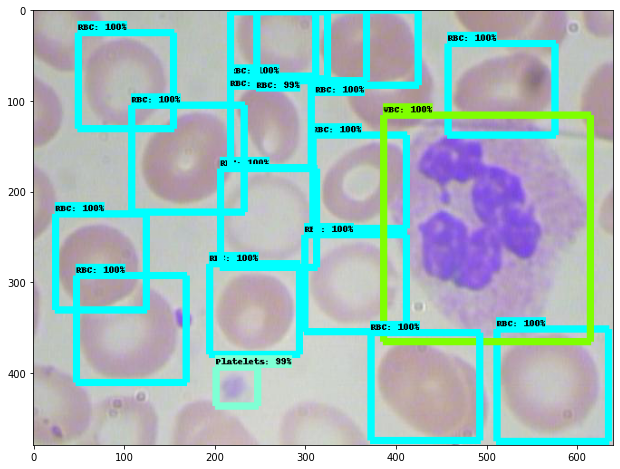

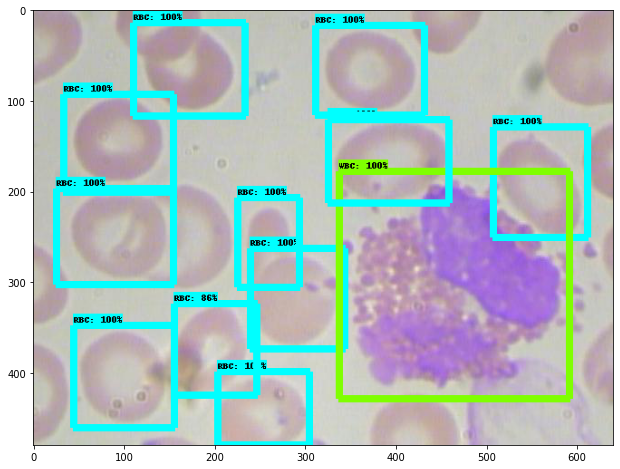

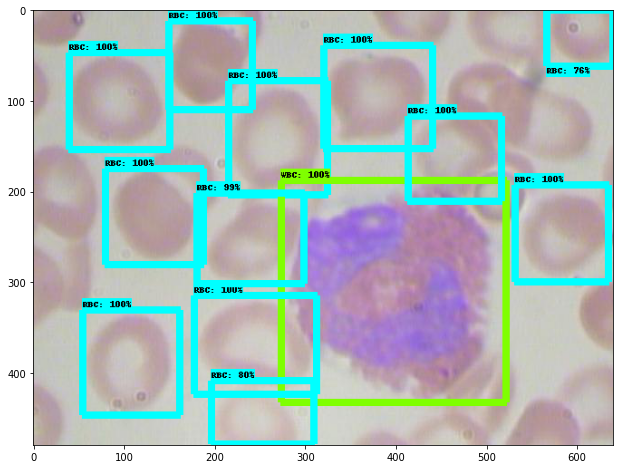

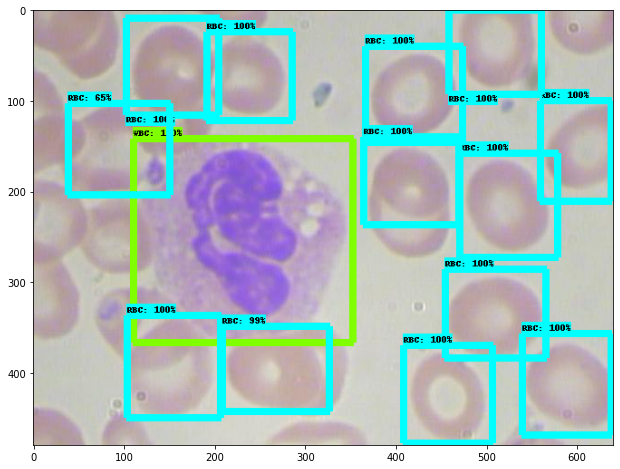

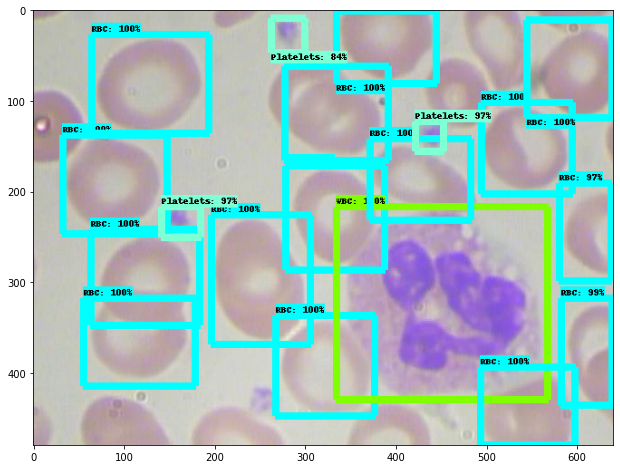

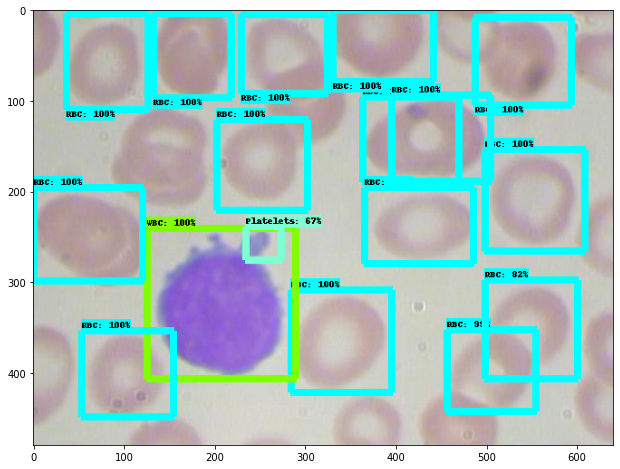

In [30]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)